In [63]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import f1_score

from diffprivlib.models import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [64]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

# Normal dataset
df = pd.read_csv('CSVFiles/small10000DomainDataBertweetEmbedded.csv')

df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

In [65]:
# Updating values for training_data, since no need for val set
training_data = df[(df['split'] == 'train') | (df['split'] == 'val')]

# Getting test_data
test_data = df[df['split'] == 'test']

In [66]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  4220.0
None-toxic samples training data:  4220.0


Toxic samples test data:  710.0
None-toxic samples test data:  710.0


male: 2031.0
female: 1849.0
LGBTQ: 1372.0
christian: 1310.0
muslim: 1421.0
other_religion: 40.0
black: 1511.0
white: 2184.0


In [67]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [68]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

In [82]:
epsilons = np.linspace(0.0001, 100, 1000)

modelLst = []

#epsilons = np.arange(0.01, 50)
for eps in epsilons:
    #clf = LogisticRegression(epsilon=eps, max_iter=30000, data_norm=4.979391198106228)
    clf = LogisticRegression(epsilon=eps, max_iter=30000, data_norm=5.069251772214575)
    clf.fit(X_train, Y_train)
    modelLst.append(clf)

In [132]:
#np.sum(test_data[(test_data['white'] == 1)]['toxicity'])

sort
5 toxic
15 ikke toxic

classifier
5 toxic 15 ikke toxic

40 toxic 40 ikke toxic

classifier
40 toxic 40 ikke toxic

p%-rule = 100

0.5
2.0


In [ ]:
print((5/20)/(40/80))

print((40/80)/(5/20))

In [161]:
def DemoAndF1AndAcc(model, df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[3:]:
        tempdf = df[(df[col] == 1)]      
        
        tempX = np.array(tempdf['comment_text'].values.tolist())
        tempY = np.array(tempdf['toxicity'].values.tolist())
        
        predictions = model.predict(tempX)
        
        f1_scores.append(f1_score(tempY, predictions, zero_division=1))
        accuracies.append(CheckAccuracy(tempY, predictions))
        demographics.append(col)
            
    return np.array(demographics), np.array(f1_scores), np.array(accuracies)


def pRule(model, df):
    pRules = []
    
    for col in df.columns[3:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        tempXz1 = np.array(tempdfz1['comment_text'].values.tolist())
        tempYz1 = np.array(tempdfz1['toxicity'].values.tolist())
        
        tempXz0 = np.array(tempdfz0['comment_text'].values.tolist())
        tempYz0 = np.array(tempdfz0['toxicity'].values.tolist())
        
        predictionsz1 = np.sum(model.predict(tempXz1))
        predictionsz0 = np.sum(model.predict(tempXz0))
        
        with np.errstate(divide='ignore'):
            pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
        
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)

def IndividualFairness(model, df):
    tempdf = df[(df[col] == 1)]
    
    X = np.array(tempdf['comment_text'].values.tolist())
    
    distSamples = []
    distOutputs = []
    
    predict_proba = clf.predict_proba(X)[:,0]    
    
    for i in range(len(X)):
        for j in range(len(X)):
            tempDistSample = np.linalg.norm(X[i]-X[j])
            distSamples.append(tempDistSample)
            
            tempDistOutput = np.linalg.norm(predict_proba[i]-predict_proba[j])
            distOutputs.append(tempDistOutput)
    
    distSamples = np.array(distSamples)/np.max(distSamples)
    distOutputs = np.array(distOutputs)/np.max(distOutputs)
    
    unfairScore = np.sum(distOutputs > distSamples)
    
    return unfairScore/len(distOutputs)

In [162]:
#individualFairnessArr = []

varF1 = []
varAcc = []

minMaxF1 = []
minMaxAcc = []

pRuleArr = []

accuracy = []

for model in modelLst:
    demographics, f1_scores, accuracies = DemoAndF1AndAcc(model, test_data)
    
    #print(np.min(pRule(model, df)))
    pRuleArr.append(np.min(pRule(model, df)))
    
    
    #individualFairnessArr.append(IndividualFairness(model, test_data))
    
    varF1.append(VarianceFairness(f1_scores))
    varAcc.append(VarianceFairness(accuracies))
    
    minMaxF1.append(MinMaxFairness(f1_scores))
    minMaxAcc.append(MinMaxFairness(accuracies))
    
    accuracy.append(model.score(X_test, Y_test))

<ipython-input-161-56cb3c95d2fd>:38: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-161-56cb3c95d2fd>:39: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-161-56cb3c95d2fd>:38: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-161-56cb3c95d2fd>:39: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-161-56cb3c95d2fd>:38: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-161-56cb3c95d2fd>:39: RuntimeWarning: in

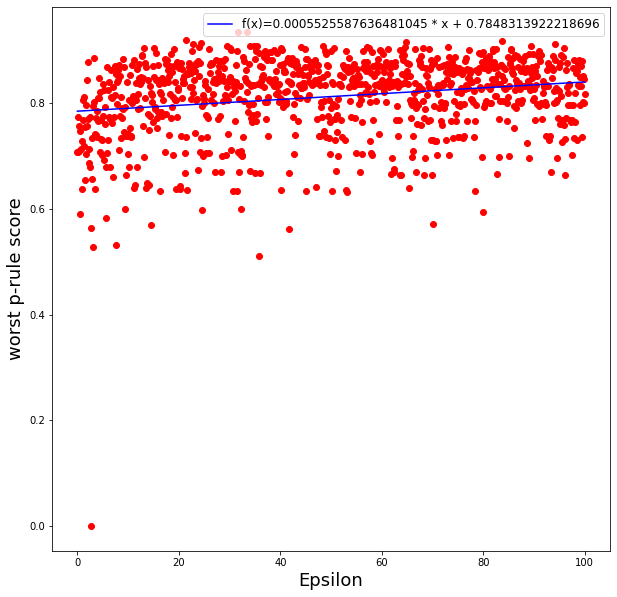

In [165]:
m, b = np.polyfit(epsilons, pRuleArr, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, pRuleArr, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("worst p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.show()

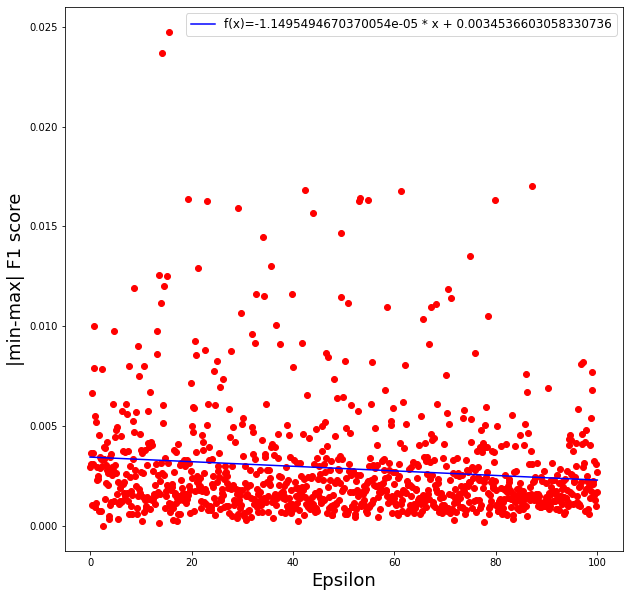

In [120]:
m, b = np.polyfit(epsilons, varF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, varF1, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("|min-max| F1 score", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.show()

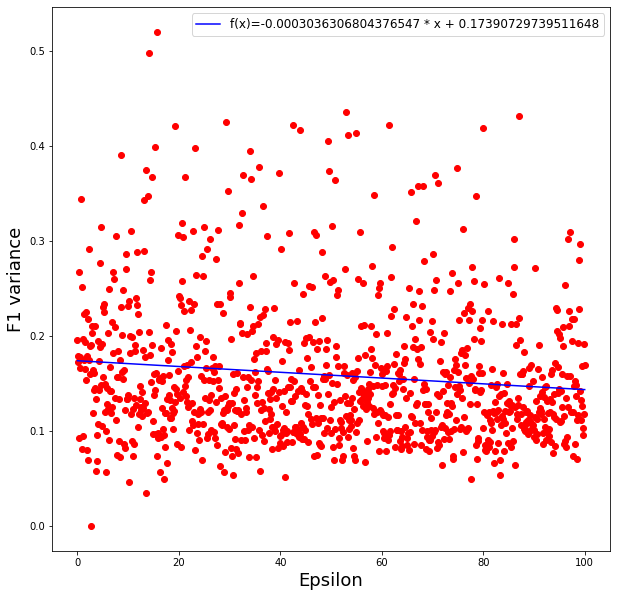

In [121]:
m, b = np.polyfit(epsilons, minMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, minMaxF1, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("F1 variance", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.show()

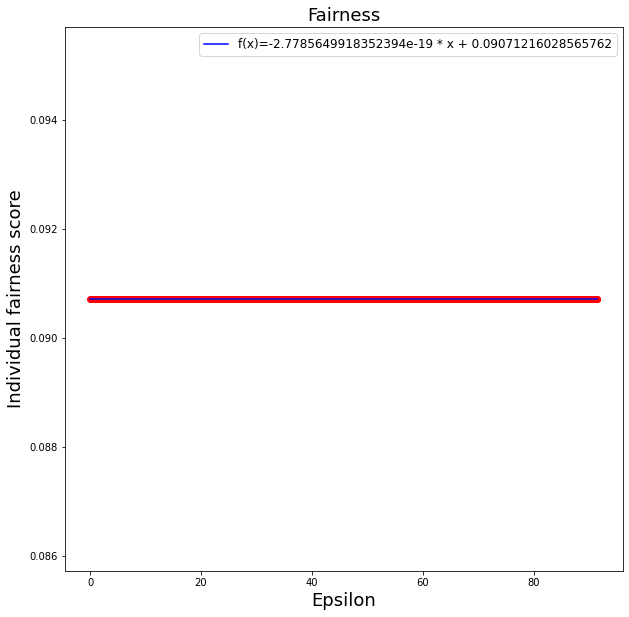

In [114]:
m, b = np.polyfit(epsilons[:len(individualFairnessArr)], individualFairnessArr, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons[:len(individualFairnessArr)], individualFairnessArr, color='r')
plt.plot(epsilons[:len(individualFairnessArr)], m*epsilons[:len(individualFairnessArr)] + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Individual fairness score", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.show()

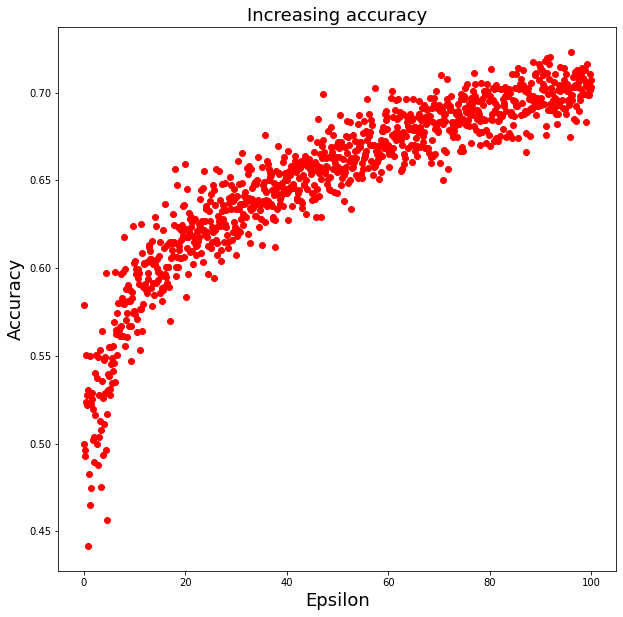

In [123]:
#m, b = np.polyfit(epsilons, minMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, accuracy, color='r')
#plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
plt.title("Increasing accuracy", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
#plt.legend(loc="upper right", fontsize=12)
plt.show()